In [31]:
CSV_FILENAME = "data/Cairo.csv"
TEXT_FILENAME = "data/warpeacetext"
JSON_FILENAME = "data/Cairo.json"
SOCCER_FILENAME = "data/pl.csv"

LIBSVM_FILE = '/home/masu/Downloads/firefox/'

# Context info

In [32]:
print("==========")
print(">>> User program\n")
print(">>> Spark version is: {}".format(sc.version))
print(">>> Spark default parallelism is: {}".format(sc.defaultParallelism))
print(">>> Spark master: {}".format(sc.master))
print("==========")

>>> User program

>>> Spark version is: 1.5.1
>>> Spark default parallelism is: 8
>>> Spark master: local[*]


# opening a text file

In [33]:
print("==========")
print(">>> User program\n")
print(">>> Loading file \"{}\"".format(TEXT_FILENAME))
text_file = sc.textFile(TEXT_FILENAME)
print(">>> Counting lines...\n")
lines_count = text_file.count()
first_len = len(text_file.first())
print(">>> {} total lines".format(str(lines_count)))
print(">>> Length of the first line: {}".format(first_len))
print("==========")
first_3 = text_file.take(3)
print("\n".join(first_3))
print("==========")

>>> User program

>>> Loading file "data/warpeacetext"
>>> Counting lines...

>>> 54223 total lines
>>> Length of the first line: 42
                                      1869
                                 WAR AND PEACE
                                 by Leo Tolstoy


# opening a csv file

In [34]:
print("==========")
print(">>> User program\n")
print(">>> Loading file \"{}\"".format(CSV_FILENAME))
csv = sc.textFile(CSV_FILENAME)
# Split lines by ','
header_and_rows = csv.map(lambda line: line.split(","))
header = header_and_rows.first()
print(">>> CSV file header:\n{}".format(" ".join(header)))
# Check if the line, and the header does not march
rows = header_and_rows.filter(lambda x: x != header)
print(">>> First row:\n{}".format(" ".join(rows.first())))
print("==========")

import json
JSON_FILENAME = "/home/masu/Cairo.json"

with open(JSON_FILENAME, "w") as fout:
    to_dict = lambda row: dict(filter(lambda x: x[0] != "", zip(header, row)))
    data = [to_dict(row) for row in rows.collect()]
    json.dump(data, fout)
print("JSON file written")
print("==========")

>>> User program

>>> Loading file "data/Cairo.csv"
>>> CSV file header:
SiteId  DateHrGmt DateHrLwt Tsfc_F Tdew_F Twet_F Rh_PCT CldCov_PCT Thi_F Spd_KTS Dir_DEG PcpPrevHr_IN DirNormIr_WsqM Spd_MPH
>>> First row:
543621  2008-12-31-22 2009-01-01-00 44.9 42.9 43.6 93 39 44.9 1 30 0 0 1
JSON file written


# parallelize, transformation and action

## parallelize

In [35]:
TEST_ARRAY_LENGTH = 100000
x = range(TEST_ARRAY_LENGTH)
rdd = sc.parallelize(x)

## transformation

In [36]:
transformation = lambda x: round(x/2)
print("==========")
# cheating: take() is an action...
print(rdd.take(10))
# cheating: collect() is an action...
print(rdd.map(transformation).collect()[:10])
print("==========")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 0, 1, 2, 2, 2, 3, 4, 4, 4]


In [37]:
transformation1 = lambda x: x.strip().split(" ")
transformation2 = lambda x: len(x) > 0 and x[0] in ["X", "x"]
print("==========")
words = text_file.flatMap(transformation1)
# cheating: take() is an action...
print(words.take(10))
# cheating: collect() is an actions...
print(words.filter(transformation2).distinct().collect())
print("==========")

['1869', 'WAR', 'AND', 'PEACE', 'by', 'Leo', 'Tolstoy', 'BK1', 'BOOK', 'ONE:']
['x.', "XIV's", 'XXIII', 'XXX', 'XXVI', 'XIV', 'XVIII', 'XXXII', 'XXII', 'XXXVII', 'XXV', 'XXVIII', 'XV,', 'x/y', 'XIII', 'XVI', 'XVI,', 'XXXVI', 'XVII,', 'XVI?', 'XIV,', 'XX', 'XXXIII', 'XXXI', 'XXIX', 'XV', 'XII', 'XXVII', 'XXXIX', 'X,', 'XVII', 'XVIII,', 'XXXIV', 'XXXVIII', 'XIX', 'X', 'XXXV', 'XXI', 'XXIV', 'XV-', 'XI', 'XVI.', 'x']


## action

In [38]:
action = lambda x, y: x + y
print("==========")
print("Expected: {}".format(sum(x)))
print(rdd.reduce(action))
print("==========")

Expected: 4999950000
4999950000


In [39]:
cairopersisted = sc.textFile('data/Cairo.csv').persist(storageLevel=StorageLevel(False, True, False, False, 4))
# StorageLevel(useDisk, useMemory, useOffHeap, deserialized, replication=1)
cairopersisted.take(4)

['SiteId,,DateHrGmt,DateHrLwt,Tsfc_F,Tdew_F,Twet_F,Rh_PCT,CldCov_PCT,Thi_F,Spd_KTS,Dir_DEG,PcpPrevHr_IN,DirNormIr_WsqM,Spd_MPH',
 '543621,,2008-12-31-22,2009-01-01-00,44.9,42.9,43.6,93,39,44.9,1,30,0,0,1',
 '543621,,2008-12-31-23,2009-01-01-01,43.5,41.9,42.1,95,39,43.5,1,30,0,0,1',
 '543621,,2009-01-01-00,2009-01-01-02,37.4,36.8,37.1,98,17,37.4,1,350,0,0,1']

# lazy evaluation

In [40]:
%%timeit -n 3 -r 3
pass

3 loops, best of 3: 55.7 ns per loop


In [41]:
%timeit -n 30 -r 3 x = rdd.map(transformation)

30 loops, best of 3: 13.2 µs per loop


In [42]:
x = rdd.map(transformation)
%timeit -n 30 -r 3 y = x.take(1)

30 loops, best of 3: 31.9 ms per loop


In [43]:
NUMBER_OF_CYCLES = 20

print("==========")
times = []
for i in range(NUMBER_OF_CYCLES):
    rdd = sc.parallelize(range(TEST_ARRAY_LENGTH))
    timeit = %timeit -o -n 1 -r 3 [rdd.map(transformation) for _ in range(i)]
    times.append(sum(timeit.all_runs)/3)
    transformed = rdd.map(transformation)
    timeit = %timeit -o -n 1 -r 3 [transformed.cache() for _ in range(i)]
    times.append(sum(timeit.all_runs)/3)

times_transformation = times[::2]
times_action = times[1::2]
print("==========")

1 loops, best of 3: 956 ns per loop
1 loops, best of 3: 953 ns per loop
1 loops, best of 3: 6.6 µs per loop
1 loops, best of 3: 3.36 ms per loop
1 loops, best of 3: 11 µs per loop
1 loops, best of 3: 10.9 ms per loop
1 loops, best of 3: 14.6 µs per loop
1 loops, best of 3: 7.39 ms per loop
1 loops, best of 3: 42.7 µs per loop
1 loops, best of 3: 12.5 ms per loop
1 loops, best of 3: 34.4 µs per loop
1 loops, best of 3: 15.1 ms per loop
1 loops, best of 3: 26.4 µs per loop
1 loops, best of 3: 13.2 ms per loop
1 loops, best of 3: 30.3 µs per loop
1 loops, best of 3: 23.2 ms per loop
1 loops, best of 3: 74.7 µs per loop
1 loops, best of 3: 28.6 ms per loop
1 loops, best of 3: 35.4 µs per loop
1 loops, best of 3: 28 ms per loop
1 loops, best of 3: 87.2 µs per loop
1 loops, best of 3: 45.8 ms per loop
1 loops, best of 3: 92 µs per loop
1 loops, best of 3: 39.2 ms per loop
1 loops, best of 3: 49.4 µs per loop
1 loops, best of 3: 34.4 ms per loop
1 loops, best of 3: 76.7 µs per loop
1 loops, b

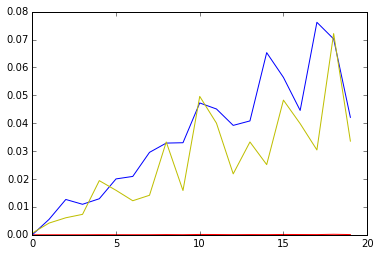

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(NUMBER_OF_CYCLES), times_transformation, 'r')
plt.plot(range(NUMBER_OF_CYCLES), times_action, 'b')
plt.plot(range(NUMBER_OF_CYCLES), [i * 400 for i in times_transformation], 'y')
plt.show()

# Key-Value Pairs

In [55]:
rdd = sc.parallelize(range(TEST_ARRAY_LENGTH))
print(type(rdd.map(lambda x: (x % 3, x))))

<class 'pyspark.rdd.PipelinedRDD'>


In [1]:
print("==========")
keys = range(TEST_ARRAY_LENGTH)
left = zip(keys, map(lambda x: x % 3, keys))
right_keys = filter(lambda x: "7" in str(x), keys)
#print(sum(map(lambda x: int(x), "123")))
sumdigit = lambda y: sum(map(lambda x: int(x), str(y)))
right = zip(right_keys, map(sumdigit, right_keys))
left = sc.parallelize(left)
right = sc.parallelize(right)
print(left.take(4))
print(right.take(4))
print("==========")

NameError: name 'TEST_ARRAY_LENGTH' is not defined

In [18]:
print("==========")
print(left.keys().take(4))
print(right.values().count())
print(right.values().distinct().count())
print("==========")

[0, 1, 2, 3]
20475
36


## reduceByKey()

In [19]:
print("==========")
right_inverse = right.map(lambda x: (x[1], x[0]))
print(right_inverse.mapValues(lambda x: x).reduceByKey(lambda x, y: x + y).top(5))
print("==========")

[(42, 1332036), (41, 899014), (40, 3086406), (39, 5866666), (38, 5931798)]


## join()

In [20]:
print("==========")
joined = left.join(right)
print(joined.count())
for i, (l, r) in joined.take(10):
    print("{}: {} - {}".format(i, l, r))
print("==========")

20475
89472: 0 - 31
68272: 1 - 26
32736: 0 - 22
37648: 1 - 29
87840: 0 - 28
98752: 1 - 32
17312: 2 - 15
59472: 0 - 28
37104: 0 - 16
87296: 2 - 33


In [21]:
print("==========")
print(left.take(5))
print(right.take(5))
joined_outer = left.leftOuterJoin(right)
print(joined_outer.count())
print("==========")
for i, (l, r) in joined_outer.take(20):
    print("{}: {} - {}".format(i, l, r))
print("==========")
print(joined_outer.filter(lambda x: x[0] == 1).take(5))
print("==========")

[(0, 0), (1, 1), (2, 2), (3, 0), (4, 1)]
[(7, 8), (27, 10), (47, 12), (67, 7), (71, 9)]
100000
0: 0 - None
16384: 1 - None
97328: 2 - None
52592: 2 - None
27824: 2 - None
16: 1 - None
89472: 0 - 31
10912: 1 - None
32: 2 - None
68272: 1 - 26
96128: 2 - None
94384: 1 - None
32816: 2 - None
99840: 0 - None
27280: 1 - None
4912: 1 - None
64: 1 - None
30048: 0 - None
32736: 0 - 22
35680: 1 - None
[(1, (1, None))]


# Share information

## Accumulator

In [22]:
numacc = sc.accumulator(0)
def transformation1(x):
    return x.strip().split(" ")
def transformation2_acc(x):
    global numacc
    if len(x) == 0:
        return False
    if "Tolstoy" in x:
        numacc += 1
        return False
    return x[0] in ["X", "x"]

print("==========")
words = text_file.flatMap(transformation1)
# cheating: take() is an action...
print(words.take(10))
# cheating: collect() is an actions...
print(words.filter(transformation2_acc).distinct().collect())
print("==========")
print(numacc.value)
print("==========")

['1869', 'WAR', 'AND', 'PEACE', 'by', 'Leo', 'Tolstoy', 'BK1', 'BOOK', 'ONE:']
['x.', "XIV's", 'XXIII', 'XXX', 'XXVI', 'XIV', 'XVIII', 'XXXII', 'XXII', 'XXXVII', 'XXV', 'XXVIII', 'XV,', 'x/y', 'XIII', 'XVI', 'XVI,', 'XXXVI', 'XVII,', 'XVI?', 'XIV,', 'XX', 'XXXIII', 'XXXI', 'XXIX', 'XV', 'XII', 'XXVII', 'XXXIX', 'X,', 'XVII', 'XVIII,', 'XXXIV', 'XXXVIII', 'XIX', 'X', 'XXXV', 'XXI', 'XXIV', 'XV-', 'XI', 'XVI.', 'x']
10


## Broadcast variable

In [23]:
right_broadcast = right.take(10)

In [24]:
# join (1 table is small)
# without broadcast
def outerJoin(kv):
    k, v = kv
    filtered = list(filter(lambda x: x[0] == k, right_broadcast))
    if len(filtered) > 1:
        return (k, (v, filtered))
    elif len(filtered) == 1:
        return (k, (v, filtered[0]))
    else:
        return (k, (v, None))

joined = filter(lambda x: x[1][1] is not None, map(outerJoin, left.take(100)))
print(list(joined))

[(7, (1, (7, 8))), (27, (0, (27, 10))), (47, (2, (47, 12))), (67, (1, (67, 7))), (71, (2, (71, 9))), (73, (1, (73, 11))), (75, (0, (75, 13))), (77, (2, (77, 15))), (79, (1, (79, 15))), (97, (1, (97, 8)))]


In [25]:
# join (1 table is small)
# with broadcast
bc = sc.broadcast(right_broadcast)

def outerJoin(kv):
    k, v = kv
    filtered = list(filter(lambda x: x[0] == k, bc.value))
    if len(filtered) > 1:
        return (k, (v, filtered))
    elif len(filtered) == 1:
        return (k, (v, filtered[0]))
    else:
        return (k, (v, None))

joined = left.map(outerJoin).filter(lambda x: x[1][1] is not None)
print(joined.collect())
#print(joined.filter(lambda x: x[1][1] is not None).collect())

[(7, (1, (7, 8))), (27, (0, (27, 10))), (47, (2, (47, 12))), (67, (1, (67, 7))), (71, (2, (71, 9))), (73, (1, (73, 11))), (75, (0, (75, 13))), (77, (2, (77, 15))), (79, (1, (79, 15))), (97, (1, (97, 8)))]


# Spark execution plan

In [26]:
transformation1 = lambda x: x.strip().split(" ")
transformation2 = lambda x: len(x) > 0 and x[0] in ["X", "x"]
print("==========")
words = text_file.flatMap(transformation1)
# cheating: take() is an action...
print(words.take(10))
# cheating: collect() is an actions...
distinct = words.filter(transformation2).distinct()
print("==========")
print(distinct.toDebugString())
print("==========")
print(distinct.collect())
print("==========")

['1869', 'WAR', 'AND', 'PEACE', 'by', 'Leo', 'Tolstoy', 'BK1', 'BOOK', 'ONE:']
b'(2) PythonRDD[205] at RDD at PythonRDD.scala:43 []\n |  MapPartitionsRDD[204] at mapPartitions at PythonRDD.scala:374 []\n |  ShuffledRDD[203] at partitionBy at NativeMethodAccessorImpl.java:-2 []\n +-(2) PairwiseRDD[202] at distinct at <ipython-input-26-48b98f9e95a1>:8 []\n    |  PythonRDD[201] at distinct at <ipython-input-26-48b98f9e95a1>:8 []\n    |  MapPartitionsRDD[4] at textFile at NativeMethodAccessorImpl.java:-2 []\n    |  data/warpeacetext HadoopRDD[3] at textFile at NativeMethodAccessorImpl.java:-2 []'
['x.', "XIV's", 'XXIII', 'XXX', 'XXVI', 'XIV', 'XVIII', 'XXXII', 'XXII', 'XXXVII', 'XXV', 'XXVIII', 'XV,', 'x/y', 'XIII', 'XVI', 'XVI,', 'XXXVI', 'XVII,', 'XVI?', 'XIV,', 'XX', 'XXXIII', 'XXXI', 'XXIX', 'XV', 'XII', 'XXVII', 'XXXIX', 'X,', 'XVII', 'XVIII,', 'XXXIV', 'XXXVIII', 'XIX', 'X', 'XXXV', 'XXI', 'XXIV', 'XV-', 'XI', 'XVI.', 'x']


# Dataframe API & Spark SQL

In [68]:
import pandas as pd

cairodf = pd.read_csv('data/Cairo.csv')
print(cairodf.columns)
cairodf[['Twet_F', 'Thi_F']][:2]

Index(['SiteId', 'Unnamed: 1', 'DateHrGmt', 'DateHrLwt', 'Tsfc_F', 'Tdew_F',
       'Twet_F', 'Rh_PCT', 'CldCov_PCT', 'Thi_F', 'Spd_KTS', 'Dir_DEG',
       'PcpPrevHr_IN', 'DirNormIr_WsqM', 'Spd_MPH'],
      dtype='object')


Twet_F  Thi_F
0    43.6   44.9
1    42.1   43.5

In [30]:
print(sqlContext)
df = sqlContext.read.format('com.databricks.spark.csv').options(header=True, inferSchema=True).load('data/pl.csv')

# http://www.football-data.co.uk/notes.txt

In [32]:
df.take(1)

[Row(Div='E0', Date='16/08/14', HomeTeam='Arsenal', AwayTeam='Crystal Palace', FTHG=2, FTAG=1, FTR='H', HTHG=1, HTAG=1, HTR='D', Referee='J Moss', HS=14, AS=4, HST=6, AST=2, HF=13, AF=19, HC=9, AC=3, HY=2, AY=2, HR=0, AR=1, B365H=1.25, B365D=6.5, B365A=15.0, BWH=1.25, BWD=5.5, BWA=12.0, IWH=1.3, IWD=5.0, IWA=9.0, LBH=1.25, LBD=6.0, LBA=13.0, PSH=1.26, PSD=6.45, PSA=14.01, WHH=1.25, WHD=5.5, WHA=12.0, SJH='1.25', SJD='5.75', SJA='12', VCH=1.25, VCD=6.25, VCA=10.5, Bb1X2=50, BbMxH=1.3, BbAvH=1.25, BbMxD=6.7, BbAvD=5.96, BbMxA=16.0, BbAvA=12.43, BbOU=48, BbMx>2.5=1.77, BbAv>2.5=1.72, BbMx<2.5=2.26, BbAv<2.5=2.1, BbAH=24, BbAHh=-1.5, BbMxAHH=1.81, BbAvAHH=1.78, BbMxAHA=2.2, BbAvAHA=2.1)]

In [56]:
df.registerTempTable('pl')
fthg = sqlContext.sql("SELECT FTHG FROM pl WHERE HomeTeam='Liverpool'")

from pyspark.sql.functions import avg
fthg.agg(avg(fthg.FTHG)).collect()

[Row(avg(FTHG)=1.5789473684210527)]

In [66]:
fthg = sqlContext.sql("SELECT HomeTeam, avg(FTHG) FROM pl GROUP BY HomeTeaM HAVING avg(FTHG) > 2")
fthg.show()

+----------+------------------+
|  HomeTeam|               _c1|
+----------+------------------+
|  Man City|2.3157894736842106|
|Man United|2.1578947368421053|
|   Arsenal|2.1578947368421053|
+----------+------------------+



In [114]:
cairopersisted = sc.textFile('data/Cairo.csv').persist(storageLevel=StorageLevel(False, True, False, False, 4))
# StorageLevel(useDisk, useMemory, useOffHeap, deserialized, replication=1)
cairopersisted.take(4)

['SiteId,,DateHrGmt,DateHrLwt,Tsfc_F,Tdew_F,Twet_F,Rh_PCT,CldCov_PCT,Thi_F,Spd_KTS,Dir_DEG,PcpPrevHr_IN,DirNormIr_WsqM,Spd_MPH',
 '543621,,2008-12-31-22,2009-01-01-00,44.9,42.9,43.6,93,39,44.9,1,30,0,0,1',
 '543621,,2008-12-31-23,2009-01-01-01,43.5,41.9,42.1,95,39,43.5,1,30,0,0,1',
 '543621,,2009-01-01-00,2009-01-01-02,37.4,36.8,37.1,98,17,37.4,1,350,0,0,1']

In [117]:
from pyspark.sql import Row
cairopersisted.map(lambda x: x.split(',')[:4]).take(2)

[['SiteId', '', 'DateHrGmt', 'DateHrLwt'],
 ['543621', '', '2008-12-31-22', '2009-01-01-00']]

In [137]:
rows = cairopersisted.map(lambda x: x.split(',')[:4]).map(lambda x: Row(Site=x[0], Date=x[2]))
sqlContext.createDataFrame(rows).printSchema()
sqlContext.createDataFrame(rows).take(3)

root
 |-- Date: string (nullable = true)
 |-- Site: string (nullable = true)



[Row(Date='DateHrGmt', Site='SiteId'),
 Row(Date='2008-12-31-22', Site='543621'),
 Row(Date='2008-12-31-23', Site='543621')]

In [134]:
joined = sqlContext.sql('SELECT * FROM (SELECT HomeTeam, max(FTHG) maxFTHG FROM pl GROUP BY HomeTeam ORDER BY maxFTHG DESC) pl1 JOIN pl pl2 WHERE pl1.HomeTeam = pl2.HomeTeam')
joined.take(4)

[Row(HomeTeam='Stoke', maxFTHG=6, Div='E0', Date='16/08/14', HomeTeam='Stoke', AwayTeam='Aston Villa', FTHG=0, FTAG=1, FTR='A', HTHG=0, HTAG=0, HTR='D', Referee='A Taylor', HS=12, AS=7, HST=2, AST=2, HF=14, AF=9, HC=2, AC=8, HY=0, AY=3, HR=0, AR=0, B365H=1.95, B365D=3.5, B365A=4.5, BWH=1.95, BWD=3.3, BWA=3.9, IWH=2.0, IWD=3.3, IWA=3.6, LBH=1.95, LBD=3.4, LBA=4.2, PSH=1.95, PSD=3.47, PSA=4.55, WHH=1.95, WHD=3.2, WHA=4.2, SJH='1.95', SJD='3.4', SJA='4', VCH=1.95, VCD=3.3, VCA=4.75, Bb1X2=50, BbMxH=2.0, BbAvH=1.92, BbMxD=3.5, BbAvD=3.38, BbMxA=4.8, BbAvA=4.27, BbOU=44, BbMx>2.5=2.42, BbAv>2.5=2.31, BbMx<2.5=1.67, BbAv<2.5=1.6, BbAH=23, BbAHh=-0.5, BbMxAHH=1.95, BbAvAHH=1.91, BbMxAHA=2.02, BbAvAHA=1.96),
 Row(HomeTeam='Stoke', maxFTHG=6, Div='E0', Date='13/09/14', HomeTeam='Stoke', AwayTeam='Leicester', FTHG=0, FTAG=1, FTR='A', HTHG=0, HTAG=0, HTR='D', Referee='M Oliver', HS=24, AS=8, HST=4, AST=1, HF=8, AF=15, HC=13, AC=3, HY=3, AY=0, HR=0, AR=0, B365H=2.1, B365D=3.4, B365A=4.0, BWH=2.15,

In [136]:
joined.select('maxFTHG', 'FTHG').write.format('parquet').save('data/joined.parquet')

## Catalyst

In [81]:
import pyspark.sql.functions as f
cairodf = sqlContext.read.format('com.databricks.spark.csv').options(header=True, inferSchema=True).load('data/Cairo.csv')
dfx = cairodf.groupBy("DateHrGmt").agg(cairodf["DateHrGmt"], f.mean("Twet_F"))
dfx.show()

+-------------+-------------+-----------+
|    DateHrGmt|    DateHrGmt|avg(Twet_F)|
+-------------+-------------+-----------+
|2009-01-04-16|2009-01-04-16|       37.7|
|2009-01-07-22|2009-01-07-22|       47.3|
|2009-01-25-04|2009-01-25-04|       37.1|
|2009-01-28-10|2009-01-28-10|       53.2|
|2009-01-29-19|2009-01-29-19|       38.7|
|2009-01-30-17|2009-01-30-17|       38.5|
|2009-02-09-01|2009-02-09-01|       43.8|
|2009-02-11-08|2009-02-11-08|       52.6|
|2009-02-14-14|2009-02-14-14|       49.4|
|2009-02-17-20|2009-02-17-20|       39.3|
|2009-03-08-07|2009-03-08-07|       53.8|
|2009-03-12-11|2009-03-12-11|       55.2|
|2009-04-01-21|2009-04-01-21|       49.4|
|2009-04-18-05|2009-04-18-05|       53.2|
|2009-04-23-18|2009-04-23-18|       54.4|
|2009-05-03-00|2009-05-03-00|       53.8|
|2009-05-04-09|2009-05-04-09|       60.9|
|2009-05-07-15|2009-05-07-15|       53.9|
|2009-05-28-03|2009-05-28-03|       61.0|
|2009-06-14-07|2009-06-14-07|       65.4|
+-------------+-------------+-----

In [83]:
cairodf.describe()

DataFrame[summary: string, SiteId: string, Tsfc_F: string, Tdew_F: string, Twet_F: string, Rh_PCT: string, CldCov_PCT: string, Thi_F: string, Spd_KTS: string, Dir_DEG: string, PcpPrevHr_IN: string, DirNormIr_WsqM: string, Spd_MPH: string]

In [115]:
cairodf.explain()

Scan CsvRelation(data/Cairo.csv,true,,,",null,#,PERMISSIVE,COMMONS,false,false,null,UTF-8,true)[SiteId#511,#512,DateHrGmt#513,DateHrLwt#514,Tsfc_F#515,Tdew_F#516,Twet_F#517,Rh_PCT#518,CldCov_PCT#519,Thi_F#520,Spd_KTS#521,Dir_DEG#522,PcpPrevHr_IN#523,DirNormIr_WsqM#524,Spd_MPH#525]



# Spark Streaming

not here...

# Spark tasks

## Task 1.

Háború és béke...

Keressük meg, hogy hány olyan sor van, amelyben legalább két nagy T betűvel kezdődő szó is szerepel.

## Solution 1.

In [ ]:
wp = sc.textFile('/home/masu/warpeacetext')
testword = lambda word: len(word) > 0 and word[0] == 'T'

def testline(line):
    return len(list(filter(testword, line.split(" ")))) > 1

filtered = wp.filter(testline)
filtered.count()

## Task 2.

Háború és béke

Milyen sorban szerepel elsőként és utolsóként a Kutuzov név, mint önálló szó? A sor sorszámára lenne szükség...

`.zipWithIndex()` - ezzel lehet besorszámozni... nem olcsó...

A `min()` és a `max()` segíthet...

## Solution 2.

In [ ]:
wp = sc.textFile('/home/masu/warpeacetext').zipWithIndex()
wp = wp.filter(lambda tup: 'Kutuzov' in tup[0].split(' '))
wp = wp.values()

print(wp.min())
print(wp.max())

## Task 3.

Az előző megoldásban kétszer is végigolvastuk az RDD-t...

Hogy oldhatnánk meg ezt, hogy csak egyszer kelljen végignézni az elemeket?

## Solution 3.

In [ ]:
wp = sc.textFile('/home/masu/warpeacetext').zipWithIndex()
wp = wp.filter(lambda tup: 'Kutuzov' in tup[0].split(' '))
wp = wp.values()

def updater(tup1, tup2):
    if not isinstance(tup1, tuple):
        tup1 = (tup1, tup1)
    if not isinstance(tup2, tuple):
        tup2 = (tup2, tup2)
    return (min(tup1[0], tup2[0]), max(tup1[1], tup2[1]))
wp.reduce(updater)

## Task 4.